In [1]:
import sys
sys.path.insert(0, "/home/ubuntu/data/code/Modules/")
import skimage
import numpy as np
import pickle
import gc
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.metrics import confusion_matrix
import cv2
import matplotlib.pyplot as plt
from keras import backend
from keras.models import Sequential
from keras.losses import binary_crossentropy
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, BatchNormalization, Flatten, Dropout
from keras.optimizers import SGD,Adadelta
import DataGenerator
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.model_selection import KFold
import random
import glob
import CNN_Module as cnn_module
import models
import time

Using TensorFlow backend.


In [2]:
import imp
imp.reload(cnn_module)
imp.reload(models)

<module 'models' from '/home/ubuntu/data/code/Modules/models.py'>

In [3]:
model = models.get_luke_model_140(input_shape=(140,100,1))
#model = models.get_luke_model_noBN(140,100)
augment_train, augment_valid = cnn_module.get_augmentations_train_test()
params_train, params_test = cnn_module.get_params_train_test(140,100,augment_valid,augment_valid)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
sample_gap=10
epochs=30
stepsperepoch=100
k = 5
video_path = '/cropped_video100_140'


start = time.time()    

augment_train, augment_valid = cnn_module.get_augmentations_train_test()
params_train, params_test = cnn_module.get_params_train_test(140,100,augment_valid,augment_valid)

#prep cells for feeding into CNN
cipro_con_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/resistant/'))
trim_con_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/trimdata/resistant/'))
#ceph_con_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/cephdata/resistant/'))

cipro_sus_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/susceptible/'))
trim_sus_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/trimdata/susceptible/'))
#ceph_sus_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/cephdata/susceptible/'))

### mix of 2
control_cells = np.append(cipro_con_cells, trim_con_cells)
sus_cells = np.append(cipro_sus_cells, trim_sus_cells)

### mix of 3
#con_cells1 = np.append(cipro_con_cells, trim_con_cells)
#sus_cells1 = np.append(cipro_sus_cells, trim_sus_cells)

#control_cells = cipro_con_cells
#control_cells = np.append(con_cells1, ceph_con_cells)
#sus_cells = np.append(sus_cells1, ceph_sus_cells)

print(len(control_cells))
print(len(sus_cells))

#label cells, and split cells into test and train, making sure to have equal proportion of sus and ctrl in both
control_cells_label = cnn_module.create_label_dict(control_cells,0)
sus_cells_label  = cnn_module.create_label_dict(sus_cells,1)

train_ctrl, test_ctrl = cnn_module.split_train_test(control_cells_label,0.9)
train_sus, test_sus = cnn_module.split_train_test(sus_cells_label,0.9)
train_labels = train_ctrl+train_sus
test_labels = test_ctrl+test_sus
print(len(train_labels))
print(test_labels)

im_paths_train, im_labels_train, im_paths_test, im_labels_test = cnn_module.get_labels_images(train_labels,test_labels,video_path,sample_gap)
random.shuffle(im_paths_train)
random.shuffle(im_paths_test)

# now all cells are labeled, add together to send to kfold as we don't need to reserve a train set
all_labels = train_labels + test_labels
random.shuffle(all_labels)

validate_steps = len(im_paths_test)//1
model = models.get_luke_model_140(input_shape=(140,100,1))
#model = models.get_luke_model_noBN(140,100)

#get kfold predictions from training set 
train_preds, kfold_val_acc, kfold_acc, kfold_val_loss = cnn_module.k_fold_train(all_labels,video_path,model,sample_gap,epochs,stepsperepoch,params_train,params_test,k)


end = time.time()
run_time = end-start
print('time =', run_time)    

564
608
1054
[('/home/ubuntu/data/resistant/sample24/cell170', 0), ('/home/ubuntu/data/resistant/sample24/cell171', 0), ('/home/ubuntu/data/resistant/sample24/cell176', 0), ('/home/ubuntu/data/resistant/sample24/cell195', 0), ('/home/ubuntu/data/resistant/sample24/cell217', 0), ('/home/ubuntu/data/resistant/sample28/cell331', 0), ('/home/ubuntu/data/resistant/sample28/cell337', 0), ('/home/ubuntu/data/resistant/sample28/cell338', 0), ('/home/ubuntu/data/resistant/sample28/cell351', 0), ('/home/ubuntu/data/resistant/sample28/cell355', 0), ('/home/ubuntu/data/resistant/sample28/cell362', 0), ('/home/ubuntu/data/resistant/sample28/cell367', 0), ('/home/ubuntu/data/resistant/sample34/cell170', 0), ('/home/ubuntu/data/resistant/sample34/cell173', 0), ('/home/ubuntu/data/resistant/sample34/cell190', 0), ('/home/ubuntu/data/resistant/sample34/cell219', 0), ('/home/ubuntu/data/resistant/sample36/cell280', 0), ('/home/ubuntu/data/resistant/sample36/cell292', 0), ('/home/ubuntu/data/resistant/sa

100/100 [==============================] - 8s 83ms/step - loss: 0.6052 - acc: 0.6775 - val_loss: 0.6892 - val_acc: 0.5294
Epoch 8/30
100/100 [==============================] - 7s 69ms/step - loss: 0.5915 - acc: 0.6878 - val_loss: 0.6400 - val_acc: 0.5914
Epoch 9/30
100/100 [==============================] - 7s 71ms/step - loss: 0.5752 - acc: 0.6912 - val_loss: 0.6765 - val_acc: 0.5625
Epoch 10/30
100/100 [==============================] - 7s 69ms/step - loss: 0.5486 - acc: 0.7084 - val_loss: 0.7103 - val_acc: 0.5402
Epoch 11/30
100/100 [==============================] - 7s 69ms/step - loss: 0.5083 - acc: 0.7428 - val_loss: 0.9269 - val_acc: 0.5947
Epoch 12/30
100/100 [==============================] - 7s 70ms/step - loss: 0.5042 - acc: 0.7372 - val_loss: 0.6564 - val_acc: 0.6001
Epoch 13/30
100/100 [==============================] - 7s 70ms/step - loss: 0.4575 - acc: 0.7622 - val_loss: 0.8125 - val_acc: 0.6219
Epoch 14/30
100/100 [==============================] - 7s 70ms/step - loss: 

In [8]:
result = (train_preds, kfold_val_acc, kfold_acc, kfold_val_loss)

In [9]:
pickle.dump(result, open('/home/ubuntu/data/code/2dCNN/kfold5_mix_bad.p','wb'))

In [10]:
import pickle
result_all = pickle.load(open('/home/ubuntu/data/code/2dCNN/kfold5_mix_bad.p','rb'))
kfold_val_acc = result_all[1]
kfold_acc = result_all[2]
kfold_val_loss = result_all[3]
#kfold_loss = result_all[4]

In [11]:
import numpy as np
val_acc_avg = np.mean(kfold_val_acc, axis = 0)
print(val_acc_avg)

[0.53739646 0.60012929 0.60394103 0.62302381 0.59524308 0.61043494
 0.69004153 0.62457724 0.59054734 0.61583998 0.65563981 0.6272392
 0.6475191  0.62467996 0.66527492 0.64080925 0.64209413 0.64679485
 0.63069297 0.66907226 0.63947287 0.66435105 0.65083416 0.63672619
 0.64837237 0.65780233 0.66971733 0.63057807 0.62106977 0.63812569]


In [12]:
import numpy as np
acc_avg = np.mean(kfold_acc, axis = 0)
print(acc_avg)

[0.5716875 0.6083125 0.629     0.654     0.681     0.7263125 0.758875
 0.7933125 0.8179375 0.8380625 0.8668125 0.885     0.904375  0.920375
 0.9340625 0.936875  0.9429375 0.9483125 0.95175   0.949125  0.95575
 0.9560625 0.9574375 0.9605    0.9586875 0.955     0.9593125 0.96
 0.9601875 0.961    ]


In [11]:
import numpy as np
val_loss_avg = np.mean(kfold_val_loss, axis = 0)
print(val_loss_avg)

[0.76420785 0.60604537 1.3032563  2.77279319 0.53764769 3.494761
 1.72972293 2.12226271 3.16654349 2.93301618 1.82047429 3.1180785
 2.98792012 2.08559396 2.34335207 2.36112905 2.71512941 3.23696663
 2.94654064 2.5777863  2.53042946 2.49012715 3.41696821 3.35008566
 1.84229092 2.23449776 2.2397184  2.05088944 3.26631417 2.00000079]


(0.5, 1)

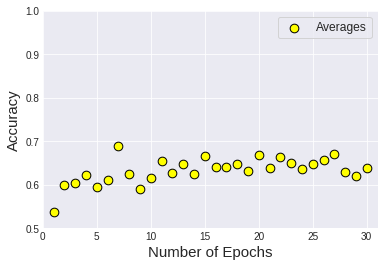

In [13]:
x_vals=np.arange(1,31)

#bests = [np.max(np.array(i)[:,1]) for i in data]
#stds = [np.std(np.array(i)[:,1]) for i in data]

plt.style.use('seaborn-darkgrid')

#plt.scatter(np.array(data)[:,0],np.array(data)[:,1],marker='x', alpha= 0.5, label='Individual runs',color='black')
plt.scatter(x_vals,val_acc_avg, marker='o', s= 75, label='Averages',color='yellow', edgecolors='black',linewidth=1)
#plt.errorbar(x_vals,data_av,std,elinewidth=2,color='maroon',label='std')
plt.legend(loc='upper right',frameon=True, fontsize=12)
#plt.title('Sample gap vs accuracy')
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('Accuracy', size = 15)
plt.xticks(np.arange(0, 35, 5))
plt.xlim(0,31)
plt.ylim(0.5,1)

#plt.savefig('/home/ubuntu/data/figs/2dk_cs_val_acc.png', dpi=500)

(0.43151432751450053, 2.5359390921933875)

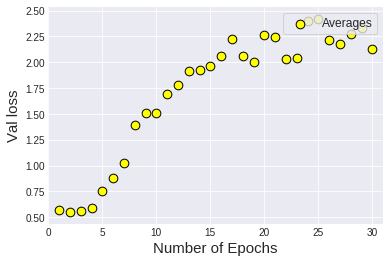

In [13]:
x_vals=np.arange(1,31)

#bests = [np.max(np.array(i)[:,1]) for i in data]
#stds = [np.std(np.array(i)[:,1]) for i in data]

plt.style.use('seaborn-darkgrid')

#plt.scatter(np.array(data)[:,0],np.array(data)[:,1],marker='x', alpha= 0.5, label='Individual runs',color='black')
plt.scatter(x_vals,val_loss_avg, marker='o', s= 75, label='Averages',color='yellow', edgecolors='black',linewidth=1)
#plt.errorbar(x_vals,data_av,std,elinewidth=2,color='maroon',label='std')
plt.legend(loc='upper right',frameon=True, fontsize=12)
#plt.title('Sample gap vs accuracy')
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('Val loss', size = 15)
plt.xticks(np.arange(0, 35, 5))
plt.xlim(0,31)
plt.ylim()

#plt.savefig('/home/ubuntu/data/figs/2dk_cs_val_acc.png', dpi=500)

(0.5, 1.05)

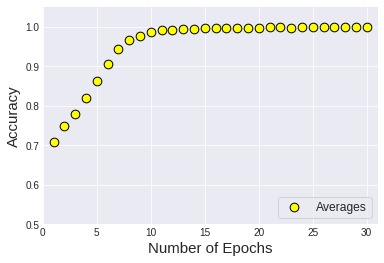

In [14]:
x_vals=np.arange(1,31)

#bests = [np.max(np.array(i)[:,1]) for i in data]
#stds = [np.std(np.array(i)[:,1]) for i in data]

plt.style.use('seaborn-darkgrid')

#plt.scatter(np.array(data)[:,0],np.array(data)[:,1],marker='x', alpha= 0.5, label='Individual runs',color='black')
plt.scatter(x_vals,acc_avg, marker='o', s= 75, label='Averages',color='yellow', edgecolors='black',linewidth=1)
#plt.errorbar(x_vals,data_av,std,elinewidth=2,color='maroon',label='std')
plt.legend(loc='lower right',frameon=True, fontsize=12)
#plt.title('Sample gap vs accuracy')
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('Accuracy', size = 15)
plt.xticks(np.arange(0, 35, 5))
plt.xlim(0,31)
plt.ylim(0.5,1.05)

#plt.savefig('/home/ubuntu/data/figs/2dk_cs_acc.png', dpi=500)

In [22]:
prediction_generator = DataGenerator.DataGenerator(im_paths_test, im_labels_test, **params_test)  
preds = model.predict_generator(generator=prediction_generator,workers=1,steps = len(im_paths_test)//24, use_multiprocessing=False)
filenames_preds = dict(zip(prediction_generator.filenames,preds))
im_result = np.array([(im_labels_test[key],np.argmax(filenames_preds[key])) for key in filenames_preds.keys()])
confusion_matrix(im_result[:,0], im_result[:,1])

array([[ 94,  50],
       [  5, 139]])

In [25]:
print('Normalised')
confusion_matrix(im_result[:,0], im_result[:,1])/144

Normalized


array([[0.65277778, 0.34722222],
       [0.03472222, 0.96527778]])

In [26]:
print('Accuracy')
(94+139)/(94+139+55)

Accuracy


0.8090277777777778

In [ ]:
test_predictions

In [ ]:
1264+176+95+745

In [ ]:
2009/2280

In [ ]:
sample_gap